In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim

import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, num_classes=4, dropout_prob=0.5):  # Add dropout_prob parameter
        super(UNet, self).__init__()

        # Encoder (Downsampling Path)
        self.encoder1 = self.contracting_block(1, 16, dropout_prob)   # Input channels = 1 (grayscale)
        self.encoder2 = self.contracting_block(16, 32, dropout_prob)
        self.encoder3 = self.contracting_block(32, 48, dropout_prob)
        self.encoder4 = self.contracting_block(48, 64, dropout_prob)
        self.bottleneck = self.contracting_block(64, 96, dropout_prob)

        # Decoder (Upsampling Path)
        self.decoder4 = self.expansive_block(96, 64, dropout_prob)   # Input: bottleneck (96)
        self.decoder3 = self.expansive_block(64 + 64, 48, dropout_prob)  # 64 (from encoder4) + 64 (from decoder4)
        self.decoder2 = self.expansive_block(48 + 48, 32, dropout_prob)  # 48 (from encoder3) + 48 (from decoder3)
        self.decoder1 = self.expansive_block(32 + 32, 16, dropout_prob)  # 32 (from encoder2) + 32 (from decoder2)
        self.upsample = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)

        # Final layer
        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1)  # Output channels: 4

    def contracting_block(self, in_channels, out_channels, dropout_prob):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Halves the size
            nn.Dropout(dropout_prob)  # Add dropout layer
        )

    def expansive_block(self, in_channels, out_channels, dropout_prob):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),  # Doubles the size
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob)  # Add dropout layer
        )

    def forward(self, x):
        enc1 = self.encoder1(x)  # (256, 256, 16)
        enc2 = self.encoder2(enc1)  # (128, 128, 32)
        enc3 = self.encoder3(enc2)  # (64, 64, 48)
        enc4 = self.encoder4(enc3)  # (32, 32, 64)
        bottleneck = self.bottleneck(enc4)  # (16, 16, 96)

        dec4 = self.decoder4(bottleneck)  # (32, 32, 64)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Concatenate (32, 32, 128)
        dec3 = self.decoder3(dec4)  # (64, 64, 48)
        dec3 = torch.cat((dec3, enc3), dim=1)  # Concatenate (64, 64, 96)
        dec2 = self.decoder2(dec3)  # (128, 128, 32)
        dec2 = torch.cat((dec2, enc2), dim=1)  # Concatenate (128, 128, 64)
        dec1 = self.decoder1(dec2)  # (256, 256, 16)
        dec1 = self.upsample(dec1)  # Upsample to match original resolution

        output = self.final_conv(dec1)  # Final output (256, 256, num_classes)
        return output

# Example instantiation of the model
dropout_probability = 0.5  # Set the desired dropout probability
model = UNet(num_classes=4, dropout_prob=dropout_probability)
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (encoder2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (encoder3): Sequential(
    (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, p

In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

class XRaySegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        # Filter images to include only .png files
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        
        # Debugging: Print the filtered list of images
        print("Filtered Images:", self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])  # Use the same name, .png extension

        # Load the image and mask
        try:
            image = Image.open(img_path).convert("L")  # Convert to grayscale for images
            mask = Image.open(mask_path).convert("L")  # Convert to grayscale for masks
            
            # Convert mask to numpy array and ensure it's of integer type
            mask = np.array(mask, dtype=np.int64)  # Ensure mask is a numpy array of type int64
            mask = torch.tensor(mask, dtype=torch.long)  # Convert to long tensor
            
            # Remove channel dimension if present
            if mask.ndimension() == 3:  # If mask is (H, W, C)
                mask = mask.squeeze(0)  # Reduce to (H, W)

            # If you end up with a shape of (N, 1, H, W), squeeze it again
            if mask.ndimension() == 3:  # If mask is still (1, H, W)
                mask = mask.squeeze(0)  # Reduce to (H, W)

        except FileNotFoundError as e:
            print(f"Error: {e}")
            # Optionally handle the missing mask case here
            mask = Image.new("L", (image.size))  # Create a blank mask if needed
            mask = torch.zeros((image.size[0], image.size[1]), dtype=torch.long)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)  # Transform the image
            # Convert mask to PIL Image before applying transformation
            mask = Image.fromarray(mask.numpy(), mode='L')  # Convert to PIL Image for mask
            mask = self.transform(mask)  # Transform the mask
            
            # Ensure the mask is still a 2D tensor (H, W) after transformation
            if mask.ndimension() == 3:  # If mask is (1, H, W) after transformation
                mask = mask.squeeze(0)  # Reduce to (H, W)

        # Ensure the mask is of long type (int) before returning
        mask = mask.long()  # Explicitly cast to long type

        return image, mask

# Example usage:
# dataset = XRaySegmentationDataset(image_dir='path/to/images', mask_dir='path/to/masks')


# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # Resize if needed
])

# Create dataset and dataloader
image_dir = "C:\\Users\\arjav\\Downloads\\Project\\AIH\\Actualmed-COVID-chestxray-dataset\\img"
mask_dir = "C:\\Users\\arjav\\Downloads\\Project\\AIH\\Actualmed-COVID-chestxray-dataset\\masks_machine"
dataset = XRaySegmentationDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

Filtered Images: ['CR.1.2.840.113564.1722810170.20200318082923328940.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200320011259312440.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200320071047906500.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200320072856343530.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200320103403375580.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200320170359875720.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200320183426328780.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200321001546031810.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200321002029359840.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200321123520296900.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200321172326140930.1003000225002.png', 'CR.1.2.840.113564.1722810170.202003211812003285.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200322160314468140.1003000225002.png', 'CR.1.2.840.113564.1722810170.20200322194859750610.1003000225

In [3]:
dropout_probability = 0.5  # Set the desired dropout probability
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)
weights = np.array([0.0008 , 0.0099 , 0.68 , 0.3093])
weights = torch.tensor(weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(weight=weights)
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for images, masks in dataloader:
        images, masks = images.to("cuda"), masks.to("cuda")
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.9f}")

print("Training complete.")


Epoch [1/20], Loss: 1.342986822
Epoch [2/20], Loss: 1.305092812
Epoch [3/20], Loss: 1.145455360
Epoch [4/20], Loss: 0.553763449
Epoch [5/20], Loss: 0.150229767
Epoch [6/20], Loss: 0.031697866
Epoch [7/20], Loss: 0.009814615
Epoch [8/20], Loss: 0.003142349
Epoch [9/20], Loss: 0.000554561
Epoch [10/20], Loss: 0.000461092
Epoch [11/20], Loss: 0.000502735
Epoch [12/20], Loss: 0.000630442
Epoch [13/20], Loss: 0.000164344
Epoch [14/20], Loss: 0.000088217
Epoch [15/20], Loss: 0.000156663
Epoch [16/20], Loss: 0.000158304
Epoch [17/20], Loss: 0.000468287
Epoch [18/20], Loss: 0.000243616
Epoch [19/20], Loss: 0.000227674
Epoch [20/20], Loss: 0.000081809
Training complete.


Average IoU: 0.2500, Average Dice: 0.2500


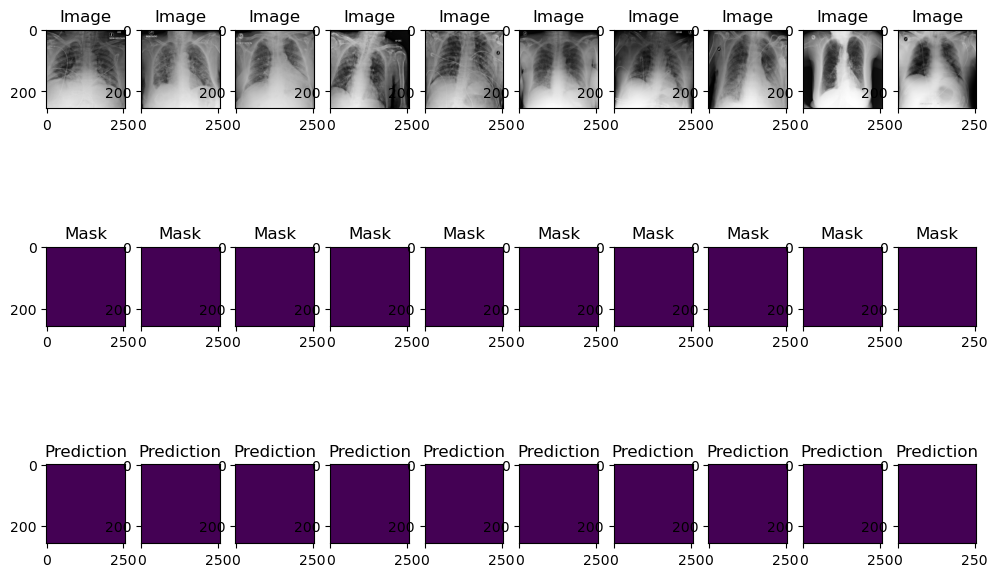

In [4]:
# Evaluation and Metrics Calculation
model.eval()
iou_scores, dice_scores = [], []
with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.to("cuda"), masks.to("cuda")
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate IoU and Dice for each class
        for cls in range(4):
            true_mask = (masks == cls)
            pred_mask = (preds == cls)
            intersection = (true_mask & pred_mask).sum().item()
            union = (true_mask | pred_mask).sum().item()
            dice = (2 * intersection) / (true_mask.sum().item() + pred_mask.sum().item() + 1e-8)
            iou = intersection / (union + 1e-8)
            iou_scores.append(iou)
            dice_scores.append(dice)
            
    avg_iou = np.mean(iou_scores)
    avg_dice = np.mean(dice_scores)
    print(f"Average IoU: {avg_iou:.4f}, Average Dice: {avg_dice:.4f}")

# Visualize some predictions
def visualize_predictions(images, masks, preds):
    fig, axs = plt.subplots(3, len(images), figsize=(12, 8))
    for i in range(len(images)):
        axs[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
        axs[0, i].set_title("Image")
        axs[1, i].imshow(masks[i].cpu(), cmap="viridis")
        axs[1, i].set_title("Mask")
        axs[2, i].imshow(preds[i].cpu(), cmap="viridis")
        axs[2, i].set_title("Prediction")
    plt.show()

# Fetch a batch for visualization
images, masks = next(iter(dataloader))
images, masks = images.to("cuda"), masks.to("cuda")
outputs = model(images)
preds = torch.argmax(outputs, dim=1)
visualize_predictions(images, masks, preds)